In [1]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from pyvis.network import Network
from scipy.io import mmread
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt 

from pyscnet import Preprocessing as pp
from pyscnet import BuildNet as bn
from pyscnet import NetEnrich as ne
from pyscnet import Plotting as pl
pd.set_option('display.max_rows', 1000)



scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.2


In [2]:
adata = sc.read_mtx('/home/mwu/MING_V9T/PhD_Pro/SC_GRN_Pro/Merge_All_SCData/Tox_WT_KO/Tox_DF.mtx')
adata.var = pd.read_csv('/home/mwu/MING_V9T/PhD_Pro/SC_GRN_Pro/Merge_All_SCData/Tox_WT_KO/Tox_DF_Gene.txt',)
adata.obs = pd.read_csv('/home/mwu/MING_V9T/PhD_Pro/SC_GRN_Pro/Merge_All_SCData/Tox_WT_KO/Tox_Design.txt', sep=' ')

adata.obs_names = adata.obs['CellName'].values
adata.var_names = adata.var['GeneName'].values

In [3]:
#preprocessing
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=100)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 9000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

filtered out 100 cells that have less than 500 genes expressed
filtered out 19598 genes that are detected in less than 100 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:
adata.X = adata.X.todense()
tox_gne = pp.load_from_scanpy(adata)

In [5]:
#select cell and features for GRN
# cell_info = tox_gne.CellAttrs['CellInfo']
# cell = list(cell_info.loc[cell_info['Condition'].isin([('Tox_KO')])].index)
# len(cell)

cell_info = pd.read_excel('/home/mwu/MING_V9T/PhD_Pro/SC_GRN_Pro/Merge_All_SCData/Tox_WT_KO/Tox_WT/cell_state.xlsx').sort_values('Pseudotime', ascending=True)
cell = list(cell_info.loc[cell_info['State'].isin(['1', '2', '3', '4', '5']), 'cell_names'])
len(cell)

4451

In [9]:
DEG_feature = pd.read_csv('/home/mwu/MING_V9T/PhD_Pro/SC_GRN_Pro/Merge_All_SCData/Tox_WT_KO/Tox_WT_Vs_KO_WilcoxDETest.tsv', index_col=0)
feature = DEG_feature.Genes

Text(0.5, 0.98, 'pairwise gene and rolling window correlation')

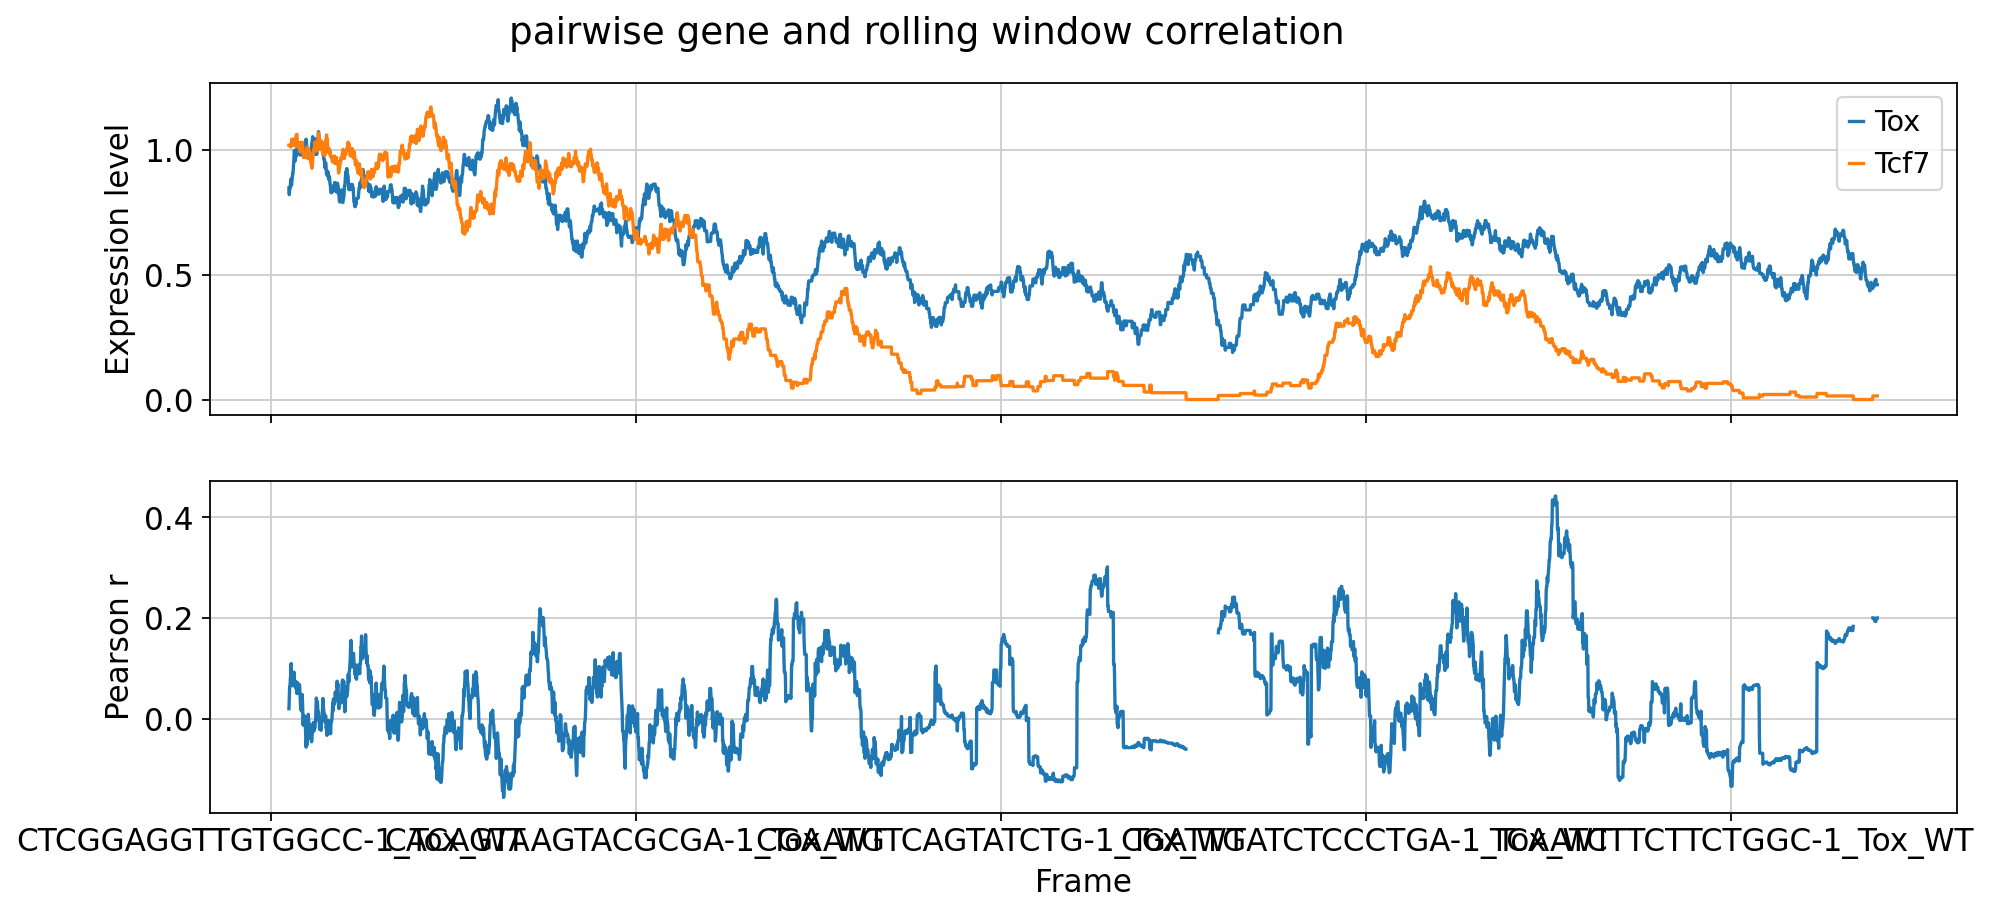

In [21]:
# Set window size to compute moving window synchrony.
r_window_size = 100
subExpr = tox_gne.ExpMatrix.loc[feature, cell]
df = subExpr.T
genes = ['Tox', 'Tcf7']
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated[genes[0]].rolling(window=r_window_size, center=True).corr(df_interpolated[genes[1]])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df[genes].rolling(window=r_window_size,center=True).mean().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Expression level')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("pairwise gene and rolling window correlation")

In [10]:
# methods_list = ['GENIE3', 'PIDC', 'GRNBOOST2']
methods_list = ['window_rolling', 'phase_synchrony']
for method in methods_list:
    if method in ['window_rolling', 'phase_synchrony']:
        tox_gne = bn.get_synchrony(tox_gne.deepcopy, method=method,
                                      feature=feature, cell=cell)
    else:
        tox_gne = bn.rundocker(tox_gne.deepcopy, method=method,
                                      feature=feature, cell=cell, directed=False)

window_rolling_links added into NetAttrs
phase_synchrony_links added into NetAttrs


In [ ]:
tox_gne.NetAttrs['GENIE3_links'].shape

In [ ]:
#build graph

tox_gne = ne.buildnet(tox_gne, key_links='PIDC_links', top=500)

#calculate node centrality
tox_gne = ne.get_centrality(tox_gne)

#detect gene community
tox_gne = ne.detect_community(tox_gne)

In [ ]:
node = 'Tox'
random_path = ne.random_walk(tox_gne, start = node, supervisedby='degree', steps=5)
random_path

In [ ]:
from pyscnet.Plotting import net_plot as npl

plt.switch_backend("cairo")
fig, ax = plt.subplots(1, 2, figsize=(40, 18))
# npl.net_matrix_plot(stream_gne, output_size=(500, 500), vertex_text_position=-2, vertex_font_size=5)
pl.net_hierarchy_plot(tox_gne, vertex_text_position=-2, vertex_size=0.2,  vertex_font_size=0.05, mplfig=ax[0])
pl.net_matrix_plot(tox_gne, vertex_text_position=-2, vertex_size=0.8,  vertex_font_size=0.2, mplfig=ax[1])
ax[0].axis('off')
ax[1].axis('off')
fig.savefig('result/net_plots.pdf')

In [11]:
tox_gne.save_as('/home/mwu/MING_V9T/PhD_Pro/SC_GRN_Pro/Merge_All_SCData/Tox_WT_KO/Tox_WT/pyscnet_tox_WT_ordered.pk')